# Endocrine and Metabolism (PHAR1019)
# Experimental Design Workshop

## 1. Introduction

### 1.1. Preamble

This is a workbook file for the Endocrine and Metabolism (PHAR1019) Experimental Design workshop.

It contains interactive elements that are designed to help students explore fundamental concepts of experimental design.

The workbook is built with a programming language called Python. It can be interacted with without any previous knowledge of programming languages or coding using a web-browser interface called JupyterLite.

**You are not expected to write code. Focus on interpreting results and making design choices.**

### 1.2. Learning Objectives
- Explain parameters relevant for experimental design tasks
- Understand design choices for experimental design
- Critically interpret and evaluate data
- Develop an experimental design
- Develop familiarity with computational thinking

### 1.3. How to use this notebook
1. Access the workbook via this web-address: [https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/](https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/)
2. Select the *Python kernel* called **Pyodide** if prompted.
3. In the menu bar at the top, click **Run → Run All Cells**.
4. You are not expected to write Python from scratch — focus on interpreting results and making design choices.

### 1.4. Workshop Scenario
The workshop will use the experimental setup of determining glucose concentrations with a yeast assay that you will conduct in *Practical 1 - Measruement of Glucose Concentrations*.

This assay is based on the fact that under anaerobic conditions, yeast produces CO₂ at a rate proportional to the amount of glucose (and other carbohydrates!) present. Hence, glucose concentrations can be related to how fast the CO₂ pressure in a closed system increases.


# Yeast CO₂ Pressure Experiment: From Question to Design

This workbook is about **experimental design**: how we decide *what to measure*, *when to measure it*, and *how many times to repeat it*, given real constraints.

We will eventually work with data (synthetic data that mimics a real experiment), but first we need to design the experiment that would generate that data.


## 1. Scientific question

**Scientific question:**  
How does **glucose concentration** influence the **CO₂ pressure generated by yeast over time**?

We care about both:
- **Magnitude** (how high does pressure get?)
- **Dynamics** (how quickly does pressure rise, and does it saturate?)


## 2. Variables in this system

In an experiment, variables fall into different roles:

- **Controlled variables (factors):** chosen by the experimenter  
- **Measured variable (response):** recorded outcome  
- **Nuisance variables:** influence results but are not the focus (noise / variability)

For this experiment:

**Controlled factors**
- Glucose concentration (set at chosen levels)
- Time points (when measurements are taken)
- Replicate number (repeat runs under the same conditions)

**Measured response**
- CO₂ pressure (a proxy for fermentation activity)

**Nuisance / uncontrolled influences (examples)**
- Yeast activity variation between runs
- Small differences in temperature or mixing
- Sensor noise / measurement error


🛑 **STOP & THINK**

1. Which variable(s) are **set by the experimenter**?  
2. Which variable is **measured**?  
3. Which nuisance factor do you think might contribute the most variability in practice?

Write a short answer before continuing.


<details>
<summary><strong>▶ Suggested answers</strong></summary>

1. Controlled: glucose level, time points, number of replicates (and other conditions such as temperature if held constant).  
2. Measured: CO₂ pressure.  
3. Likely major contributors include biological variation (yeast activity) and measurement noise.

</details>


## 3. Constraints (the reason we need design)

In the real world, we cannot measure everything. Experimental design is about making **trade-offs**.

Typical constraints:
- Limited time to run experiments
- Limited consumables / sample capacity
- Limited instrument time
- Measurement noise (replicates may be needed)

In this workbook, we will treat these as the three main design “budget choices”:
1. How many **glucose levels**?
2. How many **time points**?
3. How many **replicates** per condition?


🛑 **STOP & THINK**

Imagine you have a fixed budget that allows only **one** of the following improvements:

A) Double the number of glucose levels  
B) Double the number of time points  
C) Double the number of replicates  

Which one would you choose **for this scientific question**, and why?

(There is no single correct answer — justify your reasoning.)


## 4. What does a good design need to capture?

To answer the scientific question, the design should allow us to detect:

- **A glucose effect**: higher glucose should change pressure relative to lower glucose
- **A time effect**: pressure changes over time (not just at one moment)
- **Possible nonlinearity / saturation**: effects may plateau at high glucose or late times
- **Variability**: replicated measurements allow us to distinguish signal from noise

This leads to an important idea:

> A design must be chosen to make the *important patterns visible*.


In [42]:
# A simple "design template" (no data generation yet)

design = {
    "glucose_levels": [5, 10, 20, 40],   # mg/mL (example levels)
    "time_points_s": list(range(30, 541, 30)),  # seconds (example sampling schedule)
    "n_replicates": 3
}

design


{'glucose_levels': [5, 10, 20, 40],
 'time_points_s': [30,
  60,
  90,
  120,
  150,
  180,
  210,
  240,
  270,
  300,
  330,
  360,
  390,
  420,
  450,
  480,
  510,
  540],
 'n_replicates': 3}

## 5. What happens next?

Next, we’ll introduce **experimental design as a method**:

- thinking in a **design space**
- choosing factors and levels
- understanding what a **factorial design** means (intuitively)

After that, we’ll explore the design space interactively and then commit to one specific design to generate and analyse data.


## 2. Set-up

Before we start, we have to set up some functions and generate some synthetic data to work with.

### 2.1. Setting up the programming functions

Here, a series of codes is run to tell the software what programs (packages or libraries) are required to run the rest of the workbook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next, programs (functions) that are specific to this workbook are defined. They are mostly code that help with plotting data.

This code is particularly long and has been hidden from view to keep the workbook tidy.

In [2]:
def generate_pressure_dataset_no_missing(
    times_s=None,
    glucose_mg_ml=None,
    n_reps=1,
    seed=42,
    p_max=1200.0,
    tau=220.0,
    g_half=12.0,
    hill=1.3,
    lin_time=0.18,
    noise_abs=8.0,
    noise_rel=0.035,
):
    rng = np.random.default_rng(seed)

    if times_s is None:
        times_s = np.arange(30, 541, 30)
    else:
        times_s = np.asarray(times_s, dtype=float)

    if glucose_mg_ml is None:
        glucose_mg_ml = np.array([5, 10, 20, 40], dtype=float)
    else:
        glucose_mg_ml = np.asarray(glucose_mg_ml, dtype=float)

    # Glucose effect (Hill-type)
    f_g = (glucose_mg_ml**hill) / (g_half**hill + glucose_mg_ml**hill)

    # Time effect (saturating growth)
    f_t = 1.0 - np.exp(-times_s / tau)
    f_t = np.clip(f_t + lin_time * (times_s / times_s.max()), 0, 1.25)

    # Mean pressure surface (T × G)
    P_mean = p_max * np.outer(f_t, f_g)

    # Mild compression at high pressures
    P_mean = P_mean * (1.0 - 0.10 * (P_mean / p_max) ** 2)
    P_mean = np.clip(P_mean, 0, p_max)

    # Replicates with heteroscedastic noise
    T = times_s.size
    G = glucose_mg_ml.size
    pressure = np.empty((n_reps, T, G), dtype=float)

    for r in range(n_reps):
        eps = rng.normal(0.0, 1.0, size=(T, G))
        sigma = noise_abs + noise_rel * P_mean
        P = P_mean + sigma * eps
        pressure[r] = np.clip(P, 0, None)

    return times_s, glucose_mg_ml, pressure


def pressure_to_df(times_s, glucose_mg_ml, pressure):
    R, T, G = pressure.shape
    return pd.DataFrame({
        "replicate": np.repeat(np.arange(1, R + 1), T * G),
        "time_s": np.tile(np.repeat(times_s, G), R),
        "glucose_mg_ml": np.tile(np.tile(glucose_mg_ml, T), R),
        "pressure_mmH2O": pressure.reshape(-1),
    })


def plot_pressure_timecourses(times_s, glucose_mg_ml, pressure, rep=0):
    P = pressure[rep]
    plt.figure()
    for j, g in enumerate(glucose_mg_ml):
        plt.plot(times_s, P[:, j], marker="o", label=f"{g:g} mg/mL")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H2O)")
    plt.title("Synthetic CO₂ pressure time-courses")
    plt.legend()
    plt.show()

### 2.1. Creating a synthetic dataset

In this workshop, we will work with synthetic data, i.e., data that has been made up; however, the data structure - the range of values and the variability - is informed by realistic model data. The nature of the data is therefore reflective of what you might encounter in a real experiment.

The code calls a function that we defined above to generates this dataset.

The dataset will be stored in a table called a dataframe. We assign this dataframe to the variable *df*.

In [13]:
times_s, glucose_mg_ml, pressure = generate_pressure_dataset_no_missing(n_reps=3, seed=42)
df = pressure_to_df(times_s, glucose_mg_ml, pressure)

### 2.2. Exploring the dataset

#### 2.2.1. Dataset size and column names

To see the data, we have to tell Python to show it to us.

Let's start with asking for the number of rows and the number of columns. This is also called the *shape* of the dataframe (the table).

In [14]:
print("Dataset shape:", df.shape)

Dataset shape: (216, 4)


We can also tell Python to show us a part of the dataframe.

Here, the first 12 rows of the dataframe are returned. We can also see the column names and the indeces (running numbers) for the rows.

In [15]:
df.head(12)

,replicate,time_s,glucose_mg_ml,pressure_mmH2O
0,1,30,5.0,42.892985
1,1,30,10.0,61.761246
2,1,30,20.0,117.680928
3,1,30,40.0,148.279325
4,1,60,5.0,54.553440
5,1,60,10.0,120.083061
6,1,60,20.0,206.283630
7,1,60,40.0,250.228001
8,1,90,5.0,106.224826
9,1,90,10.0,180.470204


In [19]:
# -----------------------------
# Preconditions / setup (Code 1 contract)
# -----------------------------
required = {"time_s", "glucose_mg_ml", "pressure_mmH2O", "replicate"}

if "df" not in globals():
    raise NameError("`df` is not defined. Run the cell that generates and converts the dataset first.")

missing = required - set(df.columns)
if missing:
    raise ValueError(f"`df` is missing required columns: {missing}. Found: {list(df.columns)}")

col_time = "time_s"
col_cond = "glucose_mg_ml"
col_y    = "pressure_mmH2O"
col_rep  = "replicate"

df_sorted = df.sort_values([col_cond, col_rep, col_time]).reset_index(drop=True)

print(f"Using columns: time={col_time}, condition={col_cond}, response={col_y}, replicate={col_rep}")
print("Dataset shape:", df.shape)
display(df_sorted.head(10))

Using columns: time=time_s, condition=glucose_mg_ml, response=pressure_mmH2O, replicate=replicate
Dataset shape: (216, 4)


,replicate,time_s,glucose_mg_ml,pressure_mmH2O
0,1,30,5.0,42.892985
1,1,60,5.0,54.553440
2,1,90,5.0,106.224826
3,1,120,5.0,134.745695
4,1,150,5.0,163.217340
5,1,180,5.0,177.137276
6,1,210,5.0,192.516557
7,1,240,5.0,222.394869
8,1,270,5.0,222.950163
9,1,300,5.0,242.932746


#### 2.2.2. Number of repeat measurements and datapoints

We can also easily ask Python to group the data, for example, to show us how many repeats and how many datapoints per repeat we have in the dataset.

In [21]:
# -----------------------------
# Coverage table
# -----------------------------
if col_rep is not None:
    coverage = (
        df_sorted.groupby([col_cond, col_rep])[col_time]
        .agg(n_points="count", t_min="min", t_max="max")
        .reset_index()
        .sort_values([col_cond, col_rep])
    )
else:
    coverage = (
        df_sorted.groupby(col_cond)[col_time]
        .agg(n_points="count", t_min="min", t_max="max")
        .reset_index()
        .sort_values(col_cond)
    )

display(coverage)

,glucose_mg_ml,replicate,n_points,t_min,t_max
0,5.0,1,18,30,540
1,5.0,2,18,30,540
2,5.0,3,18,30,540
3,10.0,1,18,30,540
4,10.0,2,18,30,540
5,10.0,3,18,30,540
6,20.0,1,18,30,540
7,20.0,2,18,30,540
8,20.0,3,18,30,540
9,40.0,1,18,30,540


Each glucose concentration was measured three times. Each measurements has 18 datapoints in the timecourse.

#### 2.2.3. Summary statistics

A summary statistic gives us an overview of the distribution of the data for each set of conditions (glucose concentration, measurement timepoint).

In [22]:
# Optional: summary by condition & time (often useful for heatmap prep)
summ_time = (
    df_sorted.groupby([col_cond, col_time])[col_y]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
    .sort_values([col_cond, col_time])
)

print("\nSummary by condition & time (first 12 rows):")
display(summ_time.head(12))


Summary by condition & time (first 12 rows):


,glucose_mg_ml,time_s,mean,std,n
0,5.0,30,35.554484,6.375018,3
1,5.0,60,70.651535,16.044216,3
2,5.0,90,101.596259,13.122625,3
3,5.0,120,129.681021,9.486882,3
4,5.0,150,157.703488,10.889748,3
5,5.0,180,180.876687,9.580817,3
6,5.0,210,189.410954,9.128725,3
7,5.0,240,213.792725,7.473608,3
8,5.0,270,231.907687,21.654169,3
9,5.0,300,256.045262,11.993228,3


#### 2.2.4. Visualising the dataset

##### 2.2.4.1. Heatmap

The mean for each timepoint and glucose concentration can also be visualised, for example using a heatmap.

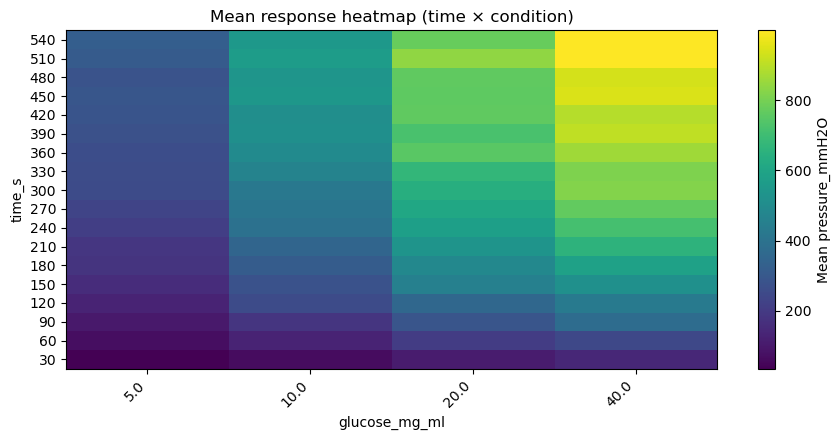

In [25]:
# -----------------------------
# 4) Heatmap: mean response across time × condition
# -----------------------------
# Pivot for heatmap: rows=time, columns=condition
heat = summ_time.pivot(index=col_time, columns=col_cond, values="mean").sort_index()

fig, ax = plt.subplots(figsize=(9, 4.5))
im = ax.imshow(
    heat.values,
    aspect="auto",
    origin="lower"
)
ax.set_title("Mean response heatmap (time × condition)")
ax.set_xlabel(col_cond)
ax.set_ylabel(col_time)

# tick labels
ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels([str(x) for x in heat.columns], rotation=45, ha="right")
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels([str(x) for x in heat.index])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Mean {col_y}")
plt.tight_layout()
plt.show()

Note how the pressure in the system is highest in the top right corner of the heatmap. This means that each concentration shows a higher pressure over time (bottom to top on the y-axis). In addition, an icnreasing glucose concentration leads to higher pressure (left to right on the x-axis).

##### 2.2.4.2. Scatter plots

Here is a visulaisation in scatter plot format.

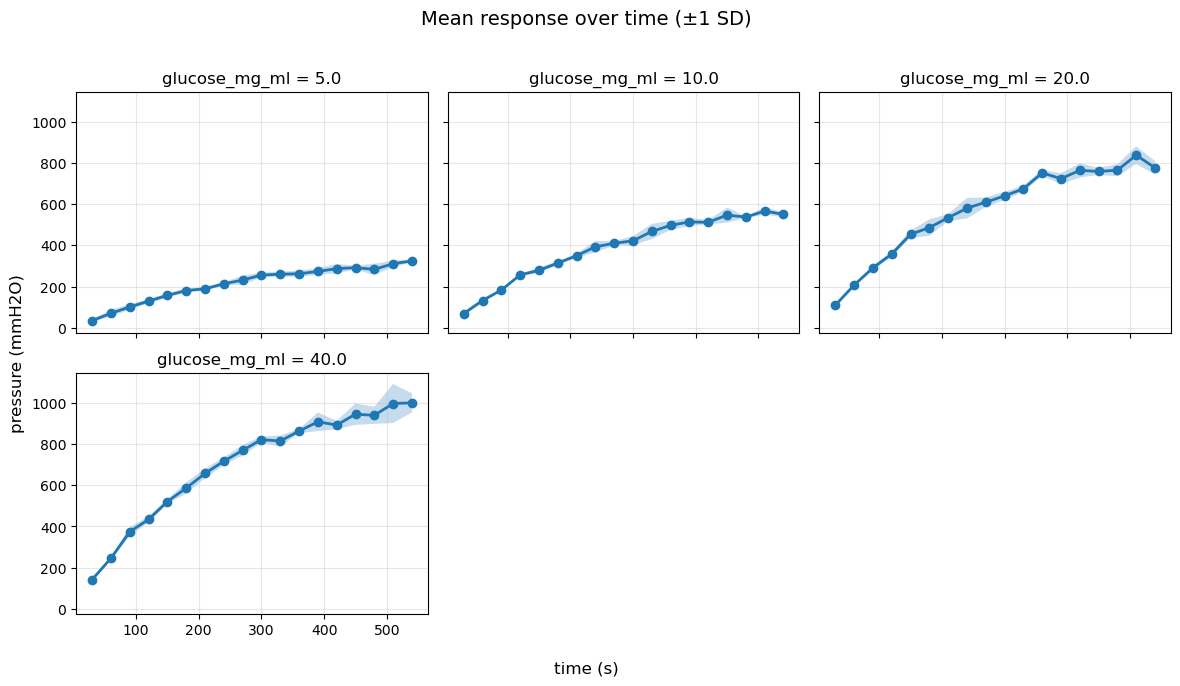

In [33]:
# -----------------------------
# 5) Small multiples: one panel per condition with mean ± SD over time
# -----------------------------
conds = list(sorted(df_sorted[col_cond].unique()))
n = len(conds)

# Arrange panels in a neat grid
ncols = 3 if n >= 3 else n
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3.3*nrows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for i, c in enumerate(conds):
    ax = axes[i]
    sub = summ_time[summ_time[col_cond] == c].sort_values(col_time)

    x = sub[col_time].to_numpy()
    y = sub["mean"].to_numpy()
    sd = sub["std"].to_numpy()

    ax.plot(x, y, marker="o", linewidth=2)
    # Only draw band where SD exists (std can be NaN if n=1)
    if np.isfinite(sd).any():
        ax.fill_between(x, y - sd, y + sd, alpha=0.25)

    ax.set_title(f"{col_cond} = {c}")
    ax.grid(True, alpha=0.3)

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Mean response over time (±1 SD)", y=1.02, fontsize=14)
#fig.supxlabel(col_time)
#fig.supylabel(col_y)
fig.supxlabel('time (s)')
fig.supylabel('pressure (mmH2O)')
plt.tight_layout()
plt.show()

The dots are the datapoints (means of 3 replicates). The light shaded area represents one standard deviation.

In the practical, you will collect and plot data of similar nature.

🛑 **STOP & THINK**

1. Which variable is *controlled* by the experimenter in this plot?
2. Which variable is *measured*?
3. Do all glucose conditions show the same *shape* of time-dependence, or do some behave differently?

Note your observations before moving on.

<details>
<summary><strong>▶ Suggested answers (click to reveal)</strong></summary>

1. **Controlled variable:**  
   Time. The experimenter chooses when measurements are taken, and the same time points are applied across all conditions.

2. **Measured variable:**  
   Pressure. This is the quantity recorded at each time point for each glucose condition.

3. **Shape of the time-dependence:**  
   The overall trend (increasing pressure with time) is similar across glucose conditions, but the *rate* of increase and the tendency to level off differ. Higher glucose concentrations typically show faster increases and earlier saturation.

This suggests that glucose affects not only the final pressure reached, but also the *dynamics* of the process.

</details>

#### 2.2.4.3. Scatterplot of pressure against glucose concentration

The data you collect in the practical has to be converted into a plot of pressure against glucose concentration. This is shown below.

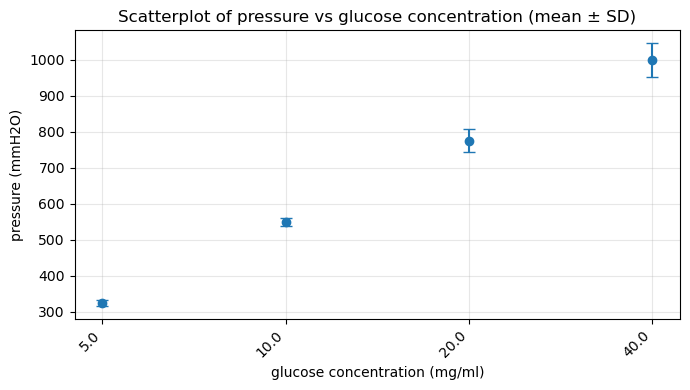

In [34]:
# -----------------------------
# 6) Endpoint view: final timepoint response vs condition (mean ± SD)
# -----------------------------
# Determine final timepoint for each condition (or overall)
# (If your experiment has the same final time for all conditions, this is equivalent.)
final_rows = (
    df_sorted.sort_values([col_cond, col_time])
    .groupby(col_cond, as_index=False)
    .tail(1)
)

# But "tail(1)" picks one row; we want endpoint stats using all replicates at final time.
# So: find final time per condition, then filter to those times.
final_time_per_cond = (
    df_sorted.groupby(col_cond)[col_time].max().reset_index().rename(columns={col_time: "final_time"})
)

df_final = df_sorted.merge(final_time_per_cond, on=col_cond, how="left")
df_final = df_final[df_final[col_time] == df_final["final_time"]]

endpoint = (
    df_final.groupby(col_cond)[col_y]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
    .sort_values(col_cond)
)

fig, ax = plt.subplots(figsize=(7, 4))
xpos = np.arange(len(endpoint))

ax.errorbar(
    xpos,
    endpoint["mean"],
    yerr=endpoint["std"],
    fmt="o",
    capsize=4
)
ax.set_xticks(xpos)
ax.set_xticklabels([str(v) for v in endpoint[col_cond]], rotation=45, ha="right")
ax.set_title("Scatterplot of pressure vs glucose concentration (mean ± SD)")
#ax.set_xlabel(col_cond)
#ax.set_ylabel(col_y)
ax.set_xlabel('glucose concentration (mg/ml)')
ax.set_ylabel('pressure (mmH2O)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🛑 **STOP & THINK**

1. In this plot, which variable is the **explanatory (independent)** variable?
2. Which variable is the **dependent (response)** variable?
3. Does the relationship appear linear across the entire glucose range, or only over part of it?

Note your observations before moving on.

<details>
<summary><strong>▶ Suggested answers (click to reveal)</strong></summary>

1. **Explanatory (independent) variable:**  
   Glucose concentration. This is the variable that is set or selected in the experiment.

2. **Dependent (response) variable:**  
   Pressure. Its value changes in response to the glucose concentration.

3. **Linearity of the relationship:**  
   The relationship appears approximately linear over a limited glucose range, but deviations are visible at higher concentrations, suggesting saturation or nonlinear behaviour.

These observations indicate that a simple linear model may be locally reasonable, but not necessarily appropriate across the full range of glucose concentrations.

</details>

#### 2.2.5. Summary statistics

Below is a table that provides the summary statistics for each glucose concentration that was extracted from the timecourse data and used to plot the scatterplot.

In [37]:
print("\nEndpoint summary:")
display(endpoint)


Endpoint summary:


,glucose_mg_ml,mean,std,n
0,5.0,324.640615,7.896621,3
1,10.0,550.117572,11.223328,3
2,20.0,775.771989,33.172985,3
3,40.0,998.943660,46.548401,3


🛑 **STOP & THINK**

1. What information is **lost** when we summarise the data using a single mean value?
2. Which aspects of the experiment are *no longer visible* in this table?
3. In what situations might summary statistics still be appropriate?

Note your observations before moving on.

<details>
<summary><strong>▶ Show suggested answers</strong></summary>

### 1. What information is lost?
- Temporal structure
- Replicate variability
- Nonlinear behaviour
- Outliers and asymmetry

### 2. What is no longer visible?
- Dynamics over time
- Rate differences
- Replicate-level behaviour
- Condition-specific trends

### 3. When are summary statistics appropriate?
- At steady state
- For screening or comparison
- For concise communication
- When dynamics are already understood

</details>